In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from dateutil import parser
import datetime
from gensim.corpora import Dictionary
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from numpy import convolve


from gensim.utils import lemmatize
from nltk.corpus import stopwords

from spacy.en import English
from nltk.stem.wordnet import WordNetLemmatizer




# nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment
import nltk
from nltk.corpus import stopwords

# gensim
import gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# visualization
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


%matplotlib inline

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
nlp = spacy.load('en')

In [3]:
sns.set_style("whitegrid")

### Import databases

In [4]:
file = open("reviews_rhinoplasty.obj",'rb')
reviews_nose = pickle.load(file)
file.close()

In [5]:
new_reviews = []
new_review = {}

for review in reviews_nose:
    for post in review['posts']:
        new_review = {}
        new_review['title'] = review['title']
        new_review['breadcrumbs'] = review['breadcrumbs']
        new_review['username'] = review['username']
        new_review['worthit'] = review['worthit']
        new_review['price'] = review['price']
        new_review['doctor'] = review['doctor']
        new_review['location'] = review['location']
        new_review['procedure_date'] = review['procedure_date']
        
        new_review['post_title'] = post['title']
        new_review['body'] = post['body']
        new_review['likes'] = post['likes']
        new_review['tags'] = post['tags']
        new_review['post_date'] = post['post_date']
        new_review['days_from_procedure'] = post['days_from_procedure']
        
        new_reviews.append(new_review)
        
reviews_date = new_reviews

In [15]:
reviews = pd.DataFrame(reviews_nose)

In [6]:
df = pd.DataFrame(reviews_date)
df['treatment'] = df['breadcrumbs'].apply(lambda x: x[1])

## Clean the Data

In [7]:
df = df.drop(['breadcrumbs', 'tags'], axis = 1)

In [8]:
df

body  days_from_procedure  \
0      Hello there! My name is Julia and I just had a...                    1   
1      So today is day number 2 after surgery and jus...                    1   
2      Hey there!!! So this is day 3 after operation ...                    2   
3      Hey guys! Today is day 4 after the surgery and...                    3   
4      Hey guys I've seen that I got some comments in...                    3   
5      Hey guys!! This is day 5 after the operation a...                    4   
6      Hey guys!!! Sorry I didn't update my blog yest...                    6   
7      Hey guys! Im sorry i haven't posted anything b...                   11   
8      Hey!! How r u guys doing?? so today is exactly...                   13   
9      Oh and I have tried to call my doctor about my...                   13   
10     Hey guys, I know it's been a while since I pos...                   19   
11     Hey guys! So today it is 1 month post-op for m...                   27   
12     Hey guys! so this is week 5 post op and the bu...                   36   
13     So today it is 6 weeks post-op and i still fee...                   41   
14     Hey guys! so its 7 weeks post-op now and I cou...                   49   
15     Hey so it's 2 months post-op now and I feel li...                   56   
16     Headed to Poland in September 2016 for rhinopl...                  180   
17     Hi everyone, I am writing to share more detail...                  365   
18     breathing is still hard but i was prescribed a...                  393   
19     More than a year later, nearly completely reco...                  365   
20     I had such a positive experience with Dr. Func...                  -15   
21     Oh the intensity, the anticipation, the chilli...                   -9   
22     MONTH BEFORE:\n             \n             Get...                   -8   
23     I'm so groggy I can hardly write... I look lik...                    3   
24     Swellling swelling swelling! I thought I was p...                   10   
25     My face is still very swollen, and there is st...                   15   
26     I took these pictures 6 weeks after surgery. T...                   47   
27     Not a whole lot has changed since month 2 - th...                   99   
28     My surgeon said at my recent follow up that I ...                  176   
29     After months and months of painful swelling, I...                  286   
...                                                  ...                  ...   
34478  Tampons removed! Extremely excited I had my ta...                    3   
34479  Today the swelling has gone down quite a bit h...                    3   
34480  Today I woke up very congested. Not being able...                    4   
34481  Not much has changed since yesterday. Today I ...                    5   
34482  I got my cast off and couldn't be any happier!...                    6   
34483  Since I am so relieved that everything came ou...                    6   
34484  So far I am very happy with the progress of my...                   25   
34485  I had a rhinoplasty by Dr Dinko and Dr Rajko T...                   30   
34486                                                                      30   
34487  I had rynoplastry because my nose was wide at ...                 1095   
34488  I have been considering rhinoplasty since I wa...                   60   
34489  I am a 22 year old male, who recently had rhin...                  120   
34490  Motivation:\n             \n             I hav...                   23   
34491                                                                      24   
34492  Having had rhinoplasty with Dr Toncic has been...                  180   
34493  It is now 19 months on since I had my revision...                  903   
34494  I requested Dr Rowe Jones to write a post surg...                  916   
34495  I couldn't breathe through my nose for years b...                    1   
34

In [9]:
def price_clean(price):
    price = price.replace(",", "").replace("$","")
    if price != "":
        return int(price)
    else:
        return 0
    
def worthit_clean(worthit):
    if (worthit != 'Worth It') and (worthit != 'Not Worth It') and (worthit != 'Not Sure'):
        return ''
    else:
        return worthit
    
def format_date(day):
    return parser.parse(day)

def get_year(day):
    return day.year

In [10]:
df = df[df['procedure_date'] != "None"]
df['post_date'] = df['post_date'].apply(format_date)
df['post_year'] = df['post_date'].apply(get_year)
df_per_year = df.groupby(['post_year']).count()
df_per_year = df_per_year['body'].reset_index()

In [17]:
#reviews['price'] = reviews['price'].apply(price_clean)
reviews['worthit'] = reviews['worthit'].apply(worthit_clean)
df['worthit'] = df['worthit'].apply(worthit_clean)
#prices = [prices for prices in reviews[reviews['price'] != '']['price']]
worthit = [reviews[reviews['worthit'] == "Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Sure"]['worthit'].count()] 

print("treatment: {}".format(df['treatment'][0]))
print("number of reviews: {}".format(len(reviews)))
print("number of unique users: {}".format(reviews.username.nunique()))
print("number of unique doctors: {}".format(reviews.doctor.nunique()))
#print("Average Price: {}{}".format(round(np.mean(prices),2), ' dollars'))

treatment: Rhinoplasty
number of reviews: 10901
number of unique users: 10873
number of unique doctors: 2762


## Explore the Data

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


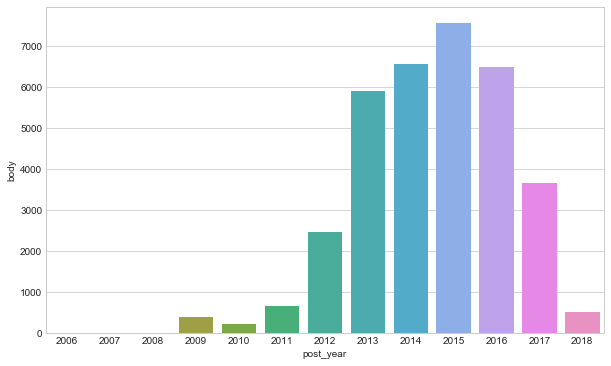

In [18]:
plt.figure(figsize = (10, 6))
sns.barplot('post_year', 'body', data= df_per_year)


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


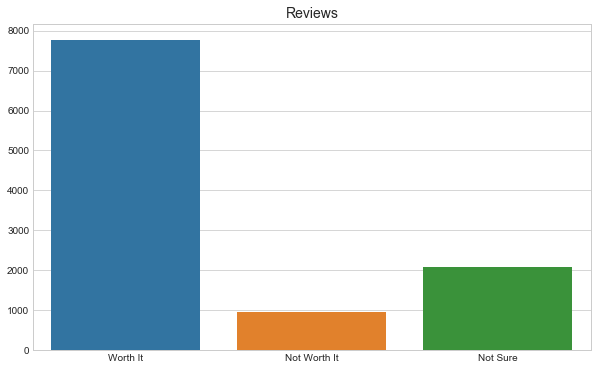

In [19]:
plt.figure(figsize = (10, 6))
sns.barplot(y= worthit, x= ["Worth It", "Not Worth It", "Not Sure"])
plt.title('Reviews', fontsize = 14)
plt.show()



In [24]:
from collections import Counter
import sys
from nltk.util import ngrams


def most_common_word_phrases(text_corpus, ngram_length=2, extra_stopwords = None,
                             nouns_only=False, doc_count=False):
    from textblob import TextBlob

    if extra_stopwords is None:
        extra_stopwords = []
    
    stop = 'english'
    stop += [".", ",", "(", ")",'"', '\\n']
    stop += extra_stopwords
    
    counter = Counter()

    for i, doc in enumerate(text_corpus):

        if i% 25000 == 0:
            print (sys.stderr, "Processing %i" % i)
        
        doc = doc.replace("\\n", " ")
        
        if ngram_length != 'noun_phrases' and nouns_only:
            words = [w for w,postag in TextBlob(doc).tags if postag == 'NN']
            words = [w for w in words if w not in stop]
        elif ngram_length != 'noun_phrases':
            words = TextBlob(doc).words
            words = [w for w in words if w not in stop]

        if ngram_length == 'noun_phrases':
            def is_legit(np):
                for stopw in stop:
                    if stopw in np:
                        return False
                return True
            N_grams = [np for np in TextBlob(doc).noun_phrases if is_legit(np)]
        else:
            N_grams = ngrams(words,ngram_length)

        if doc_count:
            N_grams = list(set(N_grams))
        
        for gram in N_grams:
            counter[gram] += 1

    #pprint( counter.most_common(100))
    return counter.most_common(250)

In [27]:
data = [post.lower() for post in df['body']]
len(data)

34508

In [28]:
most_common_word_phrases(data)

TypeError: must be str, not list

## Topic Modelling

### NMF

In [39]:
#stop words dictionary
nltk_stopwords = stopwords.words('english')+["did", "inner", "outer", "arms","treatment", "procedure", "I", "done", "coolsculpting", "area", "day", 'fat', "cool sculpting", "pain", "results", "get", "would", "sculpting", "like", "abdomen","handles", "stomach", "lower", "love", "thighs", "legs","per", "cool","made", "went", "go", "coolsculpt", "belly", "still", "little","dont","pron", "handle", "result", "i'm", "upper", "one", "-PRON-", "muffin", "top"]

no_features = 1000
no_topics = 5
no_top_words = 25


In [33]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z0-9@]", " ", text) # remove everything except numbers, hashtags, and @
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [35]:
df['body_lem'] = df['body'].apply(get_tokens)

In [36]:
lmtzr = WordNetLemmatizer()


lem_data = [lmtzr.lemmatize(post) for post in data]
#lem_data = [lmtzr.lemmatize(lmtzr.lemmatize(post,pos='v'),pos='n') for w in data]
data = lem_data

df['body'] = lem_data

In [37]:
def print_top_words(model, feature_names, n_top_words = 50):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [40]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words= 'english')
tfidf = tfidf_vectorizer.fit_transform(df['body_lem'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

print_top_words(nmf, tfidf_feature_names, 50)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):



Topic #0:
pron, say, know, tell, make, think, just, want, time, really, like, thing, nose, don, doctor, surgery, people, ve, didn, face, ask, come, work, way, surgeon, change, right, feel, life, help, sure, let, ll, try, friend, long, guy, start, talk, use, bad, ne, review, leave, thank, actually, need, good, wasn, read

Topic #1:
day, feel, pain, today, cast, sleep, swell, pron, bruise, night, good, eye, just, little, really, bad, wake, bit, surgery, tomorrow, lot, swelling, hour, swollen, start, morning, yesterday, like, pretty, eat, mouth, come, breathe, dry, wait, ve, bruising, help, splint, week, home, recovery, far, stitch, try, clean, remove, med, blood, throat

Topic #2:
dr, pron, surgery, rhinoplasty, result, procedure, staff, recommend, surgeon, consultation, happy, good, doctor, experience, year, great, make, amazing, plastic, highly, comfortable, want, question, feel, office, extremely, natural, professional, care, decide, patient, answer, job, meet, choose, work, perform,

### LDA

In [44]:
# with tf-idf
def get_topics_lda_tfidf(df, n_topics):   
    vect = TfidfVectorizer(max_df = 0.95, max_features = 1000,
                                 min_df = 5, stop_words = nltk_stopwords,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(df)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    #print topic words
    print_top_words(lda, vocab)
    
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [42]:
all_lda_tfidf, all_doc_topics_tfidf, all_prepared_tfidf = get_topics_lda_tfidf(df['body_lem'], 5)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)



Topic #0:
nose, look, tip, swell, side, see, feel, month, think, really, nostril, happy, good, week, much, bridge, swollen, swelling, say, bump, change, small, take, surgery, post, time, front, right, profile, know, bit, want, make, nose look, also, notice, even, picture, face, since, big, left, cast, smile, tell, dr, new, view, back, pic

Topic #1:
pic, post, photo, op, picture, post op, month, week, update, month post, add, month post op, happy, week post, week post op, upload, new, nose, profile, sorry, pre, surgery, see, pre op, show, swell, new nose, take, side, post pic, post picture, difference, couple, forget, last, today, excited, view, look, guy, progress, compare, believe, shot, de, hi, front, since, angle, lol

Topic #2:
nose, surgery, want, dr, look, know, think, rhinoplasty, doctor, surgeon, year, make, say, feel, really, good, time, see, tell, review, consultation, also, people, take, picture, face, find, much, decide, work, photo, thing, since, always, never, even, any

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [45]:
pyLDAvis.display(all_prepared_tfidf)

In [46]:
# with count vectorizer
def get_topics_lda(df, n_topics):   
    count_vect = CountVectorizer(analyzer = "word",
                                       stop_words = 'english',
                                       max_features = 1000, 
                                       max_df = 0.5,
                                       min_df = 2,
                                ngram_range = (1,3))
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


    # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
                learning_method='online', learning_offset=50., max_iter=10,
                random_state=0)
    
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [47]:
all_lda, all_doc_topics, all_prepared = get_topics_lda(df['body'], 5)


Topic #0:
surgery, just, like, want, really, ve, know, don, time, people, going, think, look, rhinoplasty, feel, doctor, good, dr, surgeon, said, wanted, years, didn, make, told, did, pictures, face, work, consultation, need, getting, thought, reviews, looking, life, photos, having, way, things, got, nervous, say, ll, job, long, right, decided, excited, big

Topic #1:
tip, post, bridge, op, swelling, post op, months, bump, looks, surgery, look, like, left, nostrils, did, rhinoplasty, weeks, said, hump, profile, right, happy, septum, looked, just, revision, results, nostril, breathing, surgeon, time, better, wanted, face, small, dr, doctor, year, cartilage, ago, crooked, month, told, straight, bit, removed, gone, little, smaller, days

Topic #2:
dr, surgery, rhinoplasty, results, procedure, staff, happy, did, wanted, great, surgeon, went, recommend, feel, consultation, time, amazing, doctor, best, experience, felt, questions, look, comfortable, natural, better, plastic, office, years, 

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [48]:
pyLDAvis.display(all_prepared)

In [49]:
pd.set_option('display.max_colwidth', -1)
df[(df['worthit'] == 'Not Worth It')]['body']

16       headed to poland in september 2016 for rhinoplasty with adam kalecinski. call themselves noa clinic/professional beauty. after seeing good results and reviews on their facebook page. when i arrived my consultation was incredibly rushed he seemed disinterested. it felt like a conveyor belt a lady told me they had 13 operations on the day of mine. i have been left with the same nose but in some aspects worse i cannot breathe it is wonkier from the front and i have a big bump from the side. it was hooked before the operation but never had bumps. my tip is enormous. the clinic deletes all bad reviews and only posts the very few satisfied patients results. now i will have to look for revision in the uk to correct my nose. do not go to this clinic!! they cover things up and do not care and provide no after care. they ignore your emails, rush you and provide an honestly bare minimum result. it has impacted my life beyond belief.                                                        

In [50]:
all_lda1, all_doc_topics1, all_prepared1 = get_topics_lda(df[(df['worthit'] == 'Not Worth It')]['body'], 4)



Topic #0:
dr, rhinoplasty, tip, surgery, wanted, revision, did, bump, left, crooked, doctor, septum, cartilage, years, bridge, went, said, fix, year, months, procedure, later, right, deviated, consultation, asked, post, results, correct, bone, nasal, op, removed, performed, told, nose crooked, tip nose, lip, upper, deviated septum, money, time, recommend, wide, breathe, rhinoplasty dr, fat, straight, breathing, smaller

Topic #1:
like, just, tip, really, feel, look, swelling, looks, think, post, know, op, happy, months, time, little, day, going, don, better, swollen, right, bridge, ve, good, post op, bit, cast, im, weeks, today, profile, face, days, pictures, pics, nostrils, getting, want, new, got, people, work, pretty, change, looking, looked, big, mr, nose looks

Topic #2:
surgery, surgeon, rhinoplasty, revision, just, like, dr, did, don, look, time, want, doctor, know, good, people, face, life, years, bad, tip, ve, feel, really, results, job, looking, experience, money, think, did

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [52]:
pyLDAvis.display(all_prepared1)

In [54]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [55]:
# categorize reviews by most probable topic
df['topic_LDA'] = get_doc_topics(all_doc_topics)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


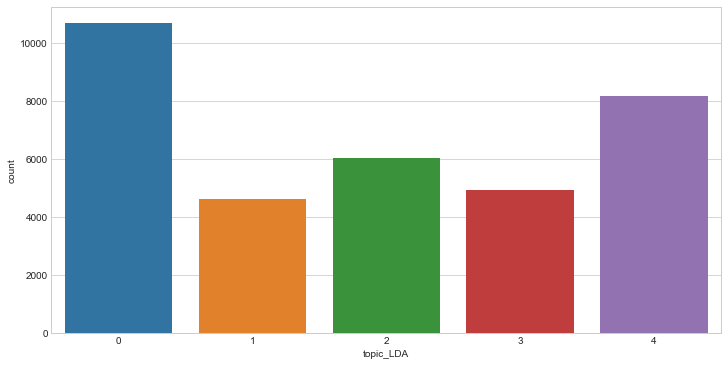

In [64]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


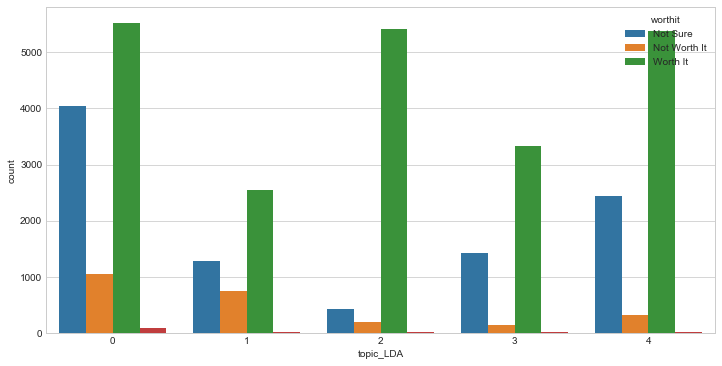

In [65]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df, hue = "worthit")

#### Organize periods

In [66]:
df['days_from_procedure'] = df[df['days_from_procedure'] <= 700]['days_from_procedure']
df['weeks_from_procedure'] = round(df['days_from_procedure'] / 7,0)
df['biweekly'] = round(df['days_from_procedure'] / 14,0)
df = df[df['weeks_from_procedure'] >0]
df = df[[df['biweekly'] >0] and df['biweekly'] < 30]

In [67]:
## aggregate days by month
def get_months(day):
    if day >= 365:
        return "over 1 year"
    elif day >= 334:
        return "11"
    elif day >= 303:
        return "10"
    elif day >= 272:
        return "11"
    elif day >= 241:
        return "09"
    elif day >= 211:
        return "08"
    elif day >= 181:
        return "07"
    elif day >= 151:
        return "06"
    elif day >= 121:
        return "05"
    elif day >= 91:
        return "04"
    elif day >= 60:
        return "03"
    elif day >= 30:
        return "02"
    else:
        return "01"
    
df['months_from_procedure'] = df['days_from_procedure'].apply(get_months) 

In [69]:
## aggregate days by periods
def get_period(day):
    if day >= 365:
        return "+1 year"
    elif day >= 210:
        return "month 6"
    elif day >= 180:
        return "month 5"
    elif day >= 126:
        return "week 19"
    elif day >= 119:
        return "week 18"
    elif day >= 112:
        return "week 17"
    elif day >= 105:
        return "week 16"
    elif day >= 98:
        return "week 15"
    elif day >= 91:
        return "week 14"
    elif day >= 84:
        return "week 13"
    elif day >= 77:
        return "week 12"
    elif day >= 70:
        return "week 11"
    elif day >= 63:
        return "week 10"
    elif day >= 56:
        return "week 9"
    elif day >= 49:
        return "week 8"
    elif day >= 42:
        return "week 7"
    elif day >= 35:
        return "week 6"
    elif day >= 28:
        return "week 5"
    elif day >= 21:
        return "week 4"
    elif day >= 14:
        return "week 3"
    elif day >= 7:
        return "week 2"
    else:
        return "week 1"
    
df['period'] = df['days_from_procedure'].apply(get_period) 

### Not Worthit Reviews

In [56]:
df_not_worthit = df[df['worthit'] == 'Not Worth It']
df_not_worthit['topic_notworthit'] = get_doc_topics(all_doc_topics1)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
most_common_word_phrases(df_not_worthit['body'], 4)

TypeError: must be str, not list

In [59]:
most_common_word_phrases(df_not_worthit['body'], 3)

TypeError: must be str, not list

In [60]:
most_common_word_phrases(df_not_worthit['body'], 2)

TypeError: must be str, not list

In [61]:
# get_stopwords(small_paragraph1_data, only_keep=100)

               
common_phrases = most_common_word_phrases(df_not_worthit['body'],
                                          ngram_length= 4,
                                          extra_stopwords=nltk_stopwords,
                                          nouns_only=False,
                                          doc_count=True)
common_phrases

TypeError: must be str, not list

In [62]:
from functools import partial

def entropy(phrase_count, corpus_size=100):
    p = float(phrase_count)/corpus_size
    return -p*np.log(p)

def entropy_of_tup(tup, corpsize=1000):
    ngram, count = tup
    return (entropy(count, corpsize), ngram)

def get_entropies_of_word_counts(word_counts, corpsize=1000):
    ent = partial(entropy_of_tup, corpsize = corpsize)
    return sorted(map(entropy_of_tup, word_counts), reverse=True)

def get_stopwords(corpus, only_keep = 1000, n=1, corpsize=1000):
    word_counts = most_common_word_phrases(corpus, n, doc_count=True)
    entropies = get_entropies_of_word_counts(word_counts, corpsize=corpsize)
    belowtop1K = entropies[only_keep:]
    return [w for ent, w in belowtop1K]

In [63]:
stop_grams = get_stopwords(df_not_worthit['body'][:1000], only_keep=50, n=4, corpsize=10)
common_phrases = most_common_word_phrases(df_not_worthit['body'][:1000], extra_stopwords=nltk_stopwords)
for ngram, count in common_phrases:
    if ngram not in stop_grams:
        print (ngram)

TypeError: must be str, not list

In [71]:
df_sorted = df.sort_values(by=['days_from_procedure'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


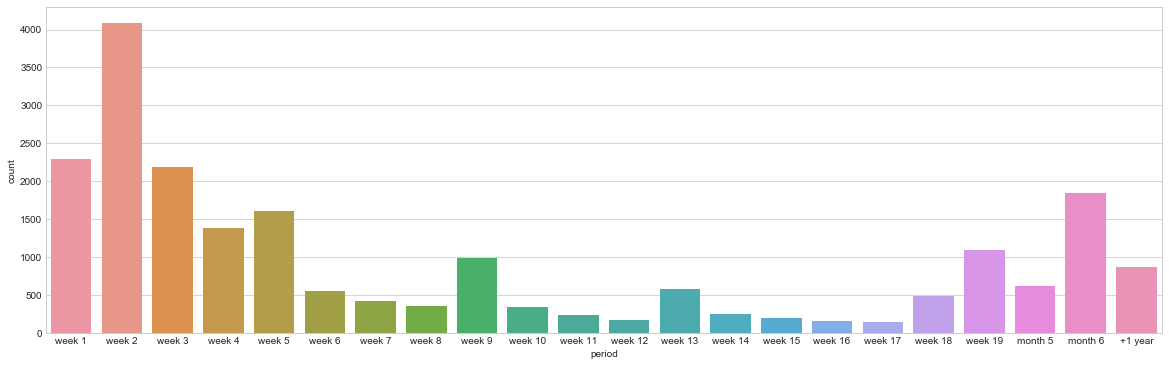

In [72]:
plt.figure(figsize = (20,6))
sns.countplot(df_sorted['period'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


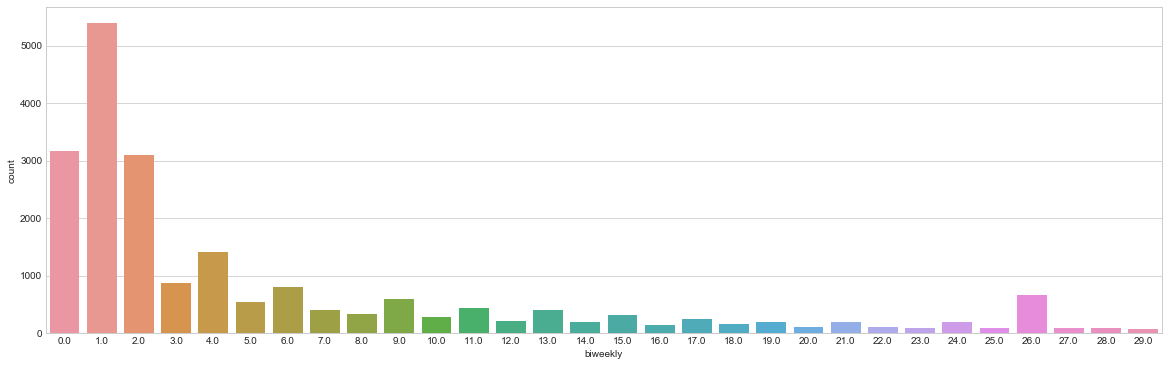

In [73]:
plt.figure(figsize = (20,6))
sns.countplot(df_sorted['biweekly'])

## Sentiment Analysis

In [76]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [77]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [TextBlob(x).sentiment[0] for x in sents]

def get_vader_sentiment(text):
    """Return vaderSentiment score for text."""
    try:
        return vaderSentiment(text)['compound']
    except:
        return 0

In [78]:
df['sentences'] = df['body'].apply(get_sentences)

In [79]:
df['sentiment_scores'] = df['sentences'].apply(get_polarity)

In [80]:
df['avg_sentiment'] = df['sentiment_scores'].apply(np.mean)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [81]:
df_sentiment = df.groupby(['days_from_procedure','avg_sentiment','worthit']).mean()
df_sentiment = df_sentiment.reset_index()
df_sentiment_not_worthit = df_sentiment[df_sentiment['worthit'] == "Not Worth It"]
df_sentiment_worthit = df_sentiment[df_sentiment['worthit'] == "Worth It"]
df_sentiment_not_sure = df_sentiment[df_sentiment['worthit'] == "Not Sure"]

Text(0.5,1,'Sentiment of Posts')

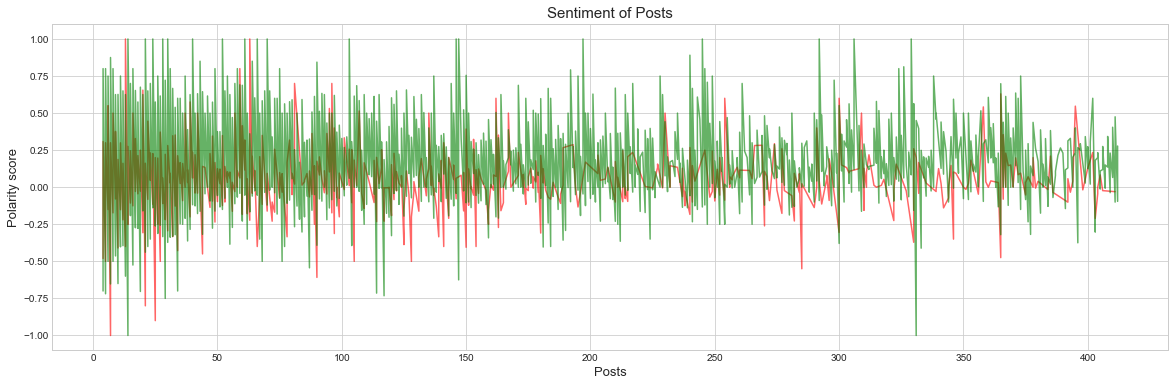

In [159]:
## plot sentiment analysis evolution
plt.figure(figsize=(20,6))
#plt.plot(df_sentiment['days_from_procedure'], df_sentiment['avg_sentiment'])
plt.plot(df_sentiment_not_worthit['days_from_procedure'], df_sentiment_not_worthit['avg_sentiment'],'r-', alpha=0.6, label = "reviews marked as not worthit")
plt.plot(df_sentiment_worthit['days_from_procedure'], df_sentiment_worthit['avg_sentiment'],'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Posts", fontsize=13)
plt.title("Sentiment of Posts", fontsize=15)

Moving Average

In [160]:
## moving average
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

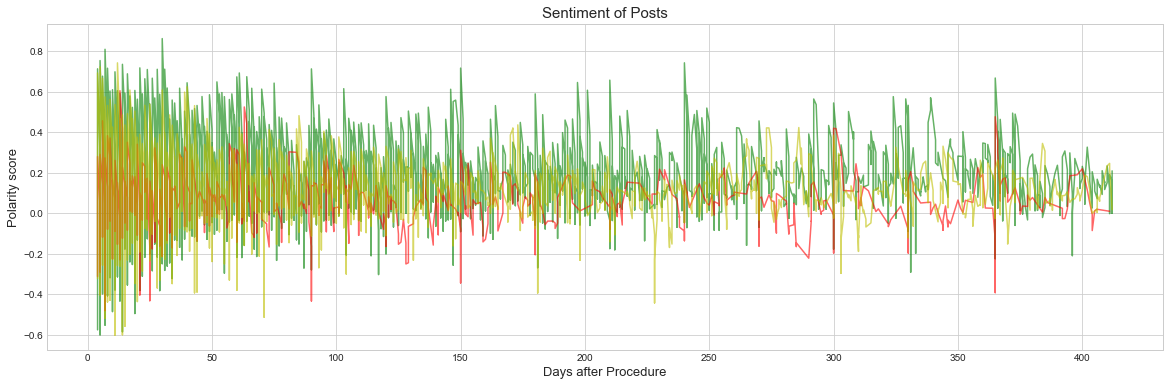

In [161]:
worthit_MA = movingaverage(df_sentiment_worthit['avg_sentiment'],3)
not_worthit_MA = movingaverage(df_sentiment_not_worthit['avg_sentiment'],3)
not_sure_MA = movingaverage(df_sentiment_not_sure['avg_sentiment'],3)

## plot sentiment analysis evolution
plt.figure(figsize=(20,6))

plt.plot(df_sentiment_worthit['days_from_procedure'][len(df_sentiment_worthit['days_from_procedure'])-len(worthit_MA):],worthit_MA,'g-', alpha=0.6)
plt.plot(df_sentiment_not_worthit['days_from_procedure'][len(df_sentiment_not_worthit['days_from_procedure'])-len(not_worthit_MA):],not_worthit_MA,'r-', alpha=0.6)
plt.plot(df_sentiment_not_sure['days_from_procedure'][len(df_sentiment_not_sure['days_from_procedure'])-len(not_sure_MA):],not_sure_MA,'y-', alpha=0.6)


#plt.plot(df_sentiment_not_worthit['days_from_procedure'], not_worthit_MA,'r-', alpha=0.6, label = "reviews marked as not worthit")
#plt.plot(df_sentiment_worthit['days_from_procedure'], worthit_MA,'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Days after Procedure", fontsize=13)
plt.title("Sentiment of Posts", fontsize=15)

plt.show()

#### Average Sentiment per Day

In [162]:
df_sentiment_not_worthit1 = df_sentiment_not_worthit.groupby(['days_from_procedure']).mean().reset_index()
df_sentiment_worthit1 = df_sentiment_worthit.groupby(['days_from_procedure']).mean().reset_index()
df_sentiment_not_sure1 = df_sentiment_not_sure.groupby(['days_from_procedure']).mean().reset_index()

Text(0.5,1,'Average Sentiment per Day')

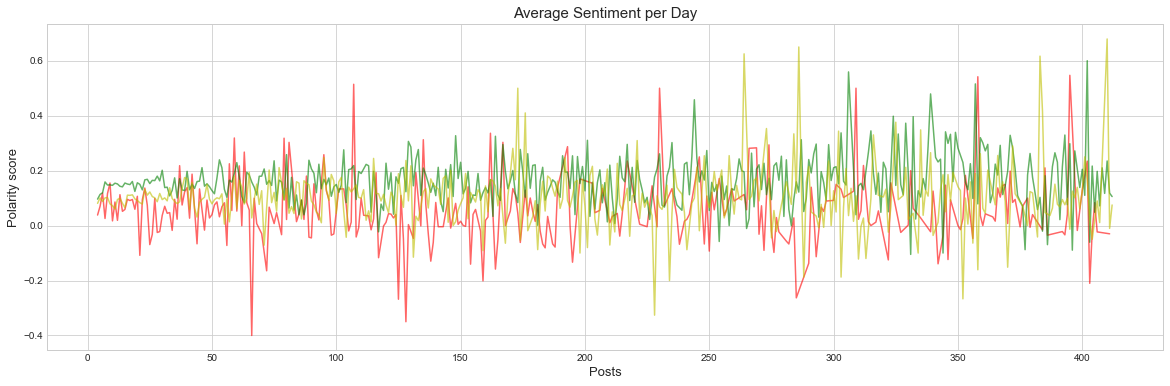

In [86]:
## plot sentiment analysis evolution
plt.figure(figsize=(20,6))
#plt.plot(df_sentiment['days_from_procedure'], df_sentiment['avg_sentiment'])
plt.plot(df_sentiment_not_worthit1['days_from_procedure'], df_sentiment_not_worthit1['avg_sentiment'],'r-', alpha=0.6, label = "reviews marked as not worthit")
plt.plot(df_sentiment_worthit1['days_from_procedure'], df_sentiment_worthit1['avg_sentiment'],'g-', alpha=0.6, label = "reviews marked as worthit")
plt.plot(df_sentiment_not_sure1['days_from_procedure'], df_sentiment_not_sure1['avg_sentiment'],'y-', alpha=0.6, label = "reviews marked as not sure")


plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Posts", fontsize=13)
plt.title("Average Sentiment per Day", fontsize=15)

Moving Average

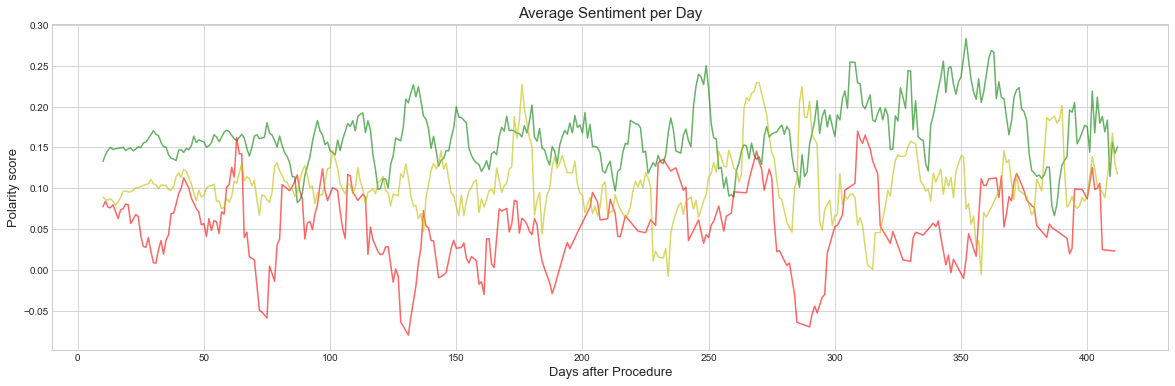

In [155]:
worthit_MA1 = movingaverage(df_sentiment_worthit1['avg_sentiment'],7)
not_worthit_MA1 = movingaverage(df_sentiment_not_worthit1['avg_sentiment'],7)
not_sure_MA1 = movingaverage(df_sentiment_not_sure1['avg_sentiment'],7)

## plot sentiment analysis evolution
plt.figure(figsize=(20,6))

plt.plot(df_sentiment_worthit1['days_from_procedure'][len(df_sentiment_worthit1['days_from_procedure'])-len(worthit_MA1):],worthit_MA1,'g-', alpha=0.6)
plt.plot(df_sentiment_not_worthit1['days_from_procedure'][len(df_sentiment_not_worthit1['days_from_procedure'])-len(not_worthit_MA1):],not_worthit_MA1,'r-', alpha=0.6)
plt.plot(df_sentiment_not_sure1['days_from_procedure'][len(df_sentiment_not_sure1['days_from_procedure'])-len(not_sure_MA1):],not_sure_MA1,'y-', alpha=0.6)


#plt.plot(df_sentiment_not_worthit['days_from_procedure'], not_worthit_MA,'r-', alpha=0.6, label = "reviews marked as not worthit")
#plt.plot(df_sentiment_worthit['days_from_procedure'], worthit_MA,'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Days after Procedure", fontsize=13)
plt.title("Average Sentiment per Day", fontsize=15)

plt.show()

#### Average Sentiment per Month

In [158]:
df_sentimentm = df.groupby(['months_from_procedure','avg_sentiment','worthit']).mean()
df_sentimentm = df_sentimentm.reset_index()
df_sentiment_not_worthitm = df_sentimentm[df_sentiment1['worthit'] == "Not Worth It"]
df_sentiment_worthitm = df_sentimentm[df_sentimentm['worthit'] == "Worth It"]
df_sentiment_not_surem = df_sentimentm[df_sentimentm['worthit'] == "Not Sure"]

In [163]:
df_sentiment_not_worthit2 = df_sentiment_not_worthitm.groupby(['months_from_procedure']).mean().reset_index()
df_sentiment_worthit2 = df_sentiment_worthitm.groupby(['months_from_procedure']).mean().reset_index()
df_sentiment_not_sure2 = df_sentiment_not_surem.groupby(['months_from_procedure']).mean().reset_index()

Text(0.5,1,'Average Sentiment per Day')

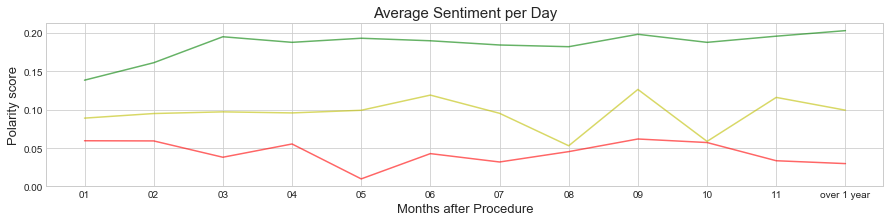

In [171]:
## plot sentiment analysis evolution
plt.figure(figsize=(15,3))
#plt.plot(df_sentiment['days_from_procedure'], df_sentiment['avg_sentiment'])
plt.plot(df_sentiment_not_worthit2['months_from_procedure'], df_sentiment_not_worthit2['avg_sentiment'],'r-', alpha=0.6, label = "reviews marked as not worthit")
plt.plot(df_sentiment_worthit2['months_from_procedure'], df_sentiment_worthit2['avg_sentiment'],'g-', alpha=0.6, label = "reviews marked as worthit")
plt.plot(df_sentiment_not_sure2['months_from_procedure'], df_sentiment_not_sure2['avg_sentiment'],'y-', alpha=0.6, label = "reviews marked as not sure")


plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Months after Procedure", fontsize=13)
plt.title("Average Sentiment per Day", fontsize=15)

Moving Average

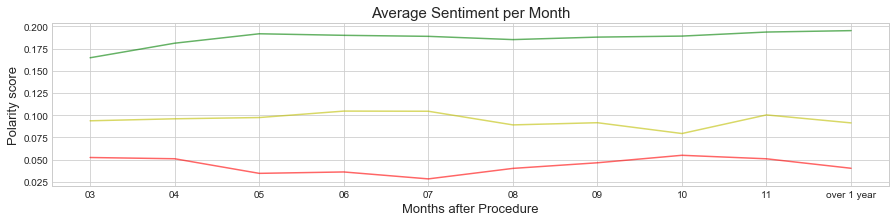

In [170]:
worthit_MA2 = movingaverage(df_sentiment_worthit2['avg_sentiment'],3)
not_worthit_MA2 = movingaverage(df_sentiment_not_worthit2['avg_sentiment'],3)
not_sure_MA2 = movingaverage(df_sentiment_not_sure2['avg_sentiment'],3)

## plot sentiment analysis evolution
plt.figure(figsize=(15,3))

plt.plot(df_sentiment_worthit2['months_from_procedure'][len(df_sentiment_worthit2['months_from_procedure'])-len(worthit_MA2):],worthit_MA2,'g-', alpha=0.6)
plt.plot(df_sentiment_not_worthit2['months_from_procedure'][len(df_sentiment_not_worthit2['months_from_procedure'])-len(not_worthit_MA2):],not_worthit_MA2,'r-', alpha=0.6)
plt.plot(df_sentiment_not_sure2['months_from_procedure'][len(df_sentiment_not_sure2['months_from_procedure'])-len(not_sure_MA2):],not_sure_MA2,'y-', alpha=0.6)


#plt.plot(df_sentiment_not_worthit['days_from_procedure'], not_worthit_MA,'r-', alpha=0.6, label = "reviews marked as not worthit")
#plt.plot(df_sentiment_worthit['days_from_procedure'], worthit_MA,'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Months after Procedure", fontsize=13)
plt.title("Average Sentiment per Month", fontsize=15)

plt.show()

### Set thresholds for negative and positive

In [88]:
def sentiment_threshold(sentiment):
    if sentiment >= 0.3:
        return "positive"
    elif sentiment <= -0.2:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['avg_sentiment'].apply(sentiment_threshold)

Text(0.5,1,'Sentiment Distribution')

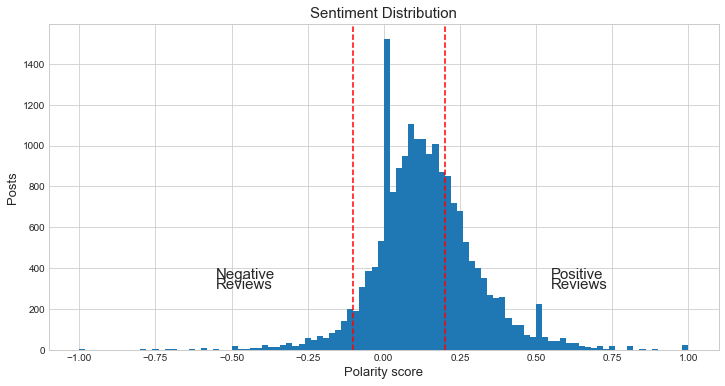

In [153]:
plt.figure(figsize=(12,6))
#sns.plot(df[df['body'] != ""]['avg_sentiment'])
plt.hist(df['avg_sentiment'].dropna(), bins = 100) # ignore NaN's
plt.axvline(x=-0.1, color="r",linestyle="dashed")
plt.axvline(x=0.2, color="r",linestyle="dashed")

plt.text(0.55, 350, "Positive", fontsize=15)
plt.text(0.55, 300, "Reviews", fontsize=15)
plt.text(-0.55, 350, "Negative", fontsize=15)
plt.text(-0.55, 300, "Reviews", fontsize=15)

plt.xlabel("Polarity score", fontsize=13)
plt.ylabel("Posts", fontsize=13)
plt.title("Sentiment Distribution", fontsize=15)

#### Save DataFrame

In [91]:
pickle.dump(df, open("reviews_topics_nose.pickle",'wb'))

In [92]:
df.to_csv("reviews_topics_nose.csv", encoding='utf-8', index=False)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


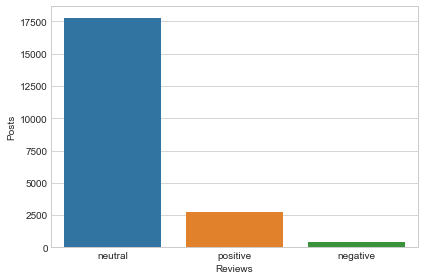

In [93]:
sns.countplot(df['sentiment'])
plt.xlabel("Reviews")
plt.ylabel("Posts")
#plt.ylim(0,4000)
plt.tight_layout()

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


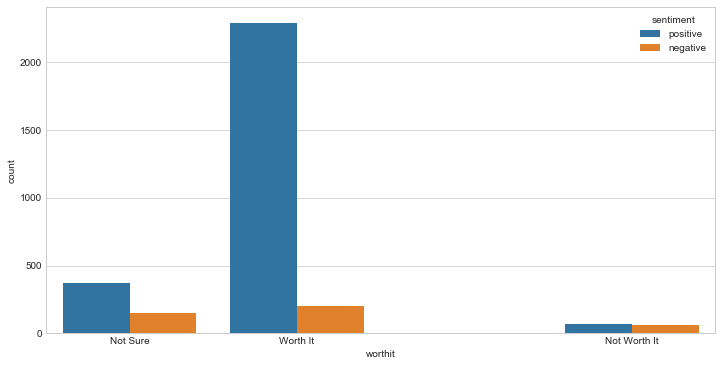

In [94]:
plt.figure(figsize=(12,6))
sns.countplot(df[df['sentiment'] != 'neutral']['worthit'], hue = df[df['sentiment'] != 'neutral']['sentiment'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


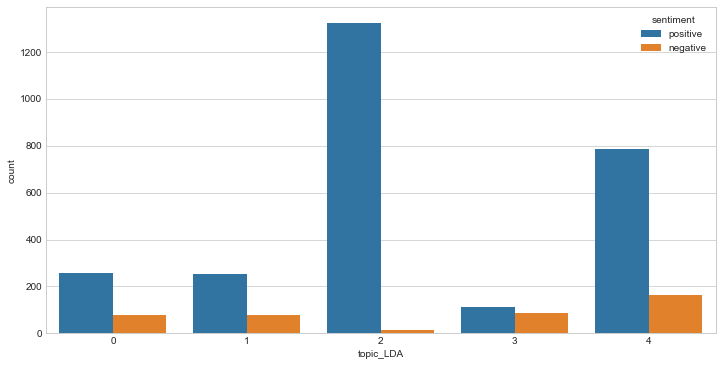

In [96]:
plt.figure(figsize=(12,6))
sns.countplot(df[df['sentiment'] != 'neutral']['topic_LDA'], hue = df[df['sentiment'] != 'neutral']['sentiment'])
#sns.countplot(df['topic'], hue = df['sentiment'])

In [97]:
df_period = df.groupby(['biweekly','topic_LDA'])
df_count_posts = df_period.topic_LDA.count()
df_count_posts = df_count_posts.unstack()

### Topics Evolution over time

In [98]:
df_count_posts

topic_LDA     0    1    2    3     4
biweekly                            
0.0        590   181  268  961  1163
1.0        1143  614  710  858  2076
2.0        656   415  760  253  1009
3.0        264   131  41   55   392 
4.0        289   210  496  98   317 
5.0        179   96   35   27   202 
6.0        184   110  326  51   140 
7.0        147   79   20   15   137 
8.0        98    69   17   23   123 
9.0        153   102  221  24   89  
10.0       88    70   13   7    101 
11.0       114   82   177  14   59  
12.0       82    47   10   16   61  
13.0       82    76   155  23   63  
14.0       71    54   15   11   49  
15.0       65    52   124  26   49  
16.0       58    30   7    5    48  
17.0       80    28   91   6    41  
18.0       57    48   12   7    44  
19.0       40    38   77   11   30  
20.0       39    26   5    3    29  
21.0       51    44   67   5    28  
22.0       37    31   5    8    23  
23.0       32    25   13   2    26  
24.0       67    40   64   2    20  
25.0       39    21   6    4    17  
26.0       181   117  307  25   30  
27.0       34    21   12   9    20  
28.0       38    20   2    8    20  
29.0       29    18   5    5    21

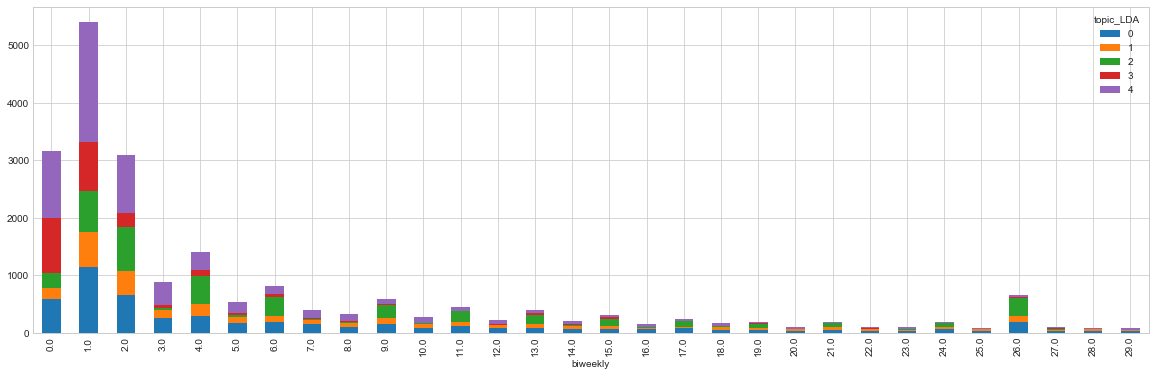

In [99]:
plt.figure(figsize=(20,6))

df_count_posts.plot(kind='bar', stacked=True, figsize=(20,6))

In [100]:
# We need to transform the data from raw data to percentage (fraction)
topic_perc = df_count_posts.divide(df_count_posts.sum(axis=1), axis=0)
topic_perc

topic_LDA         0         1         2         3         4
biweekly                                                   
0.0        0.186532  0.057224  0.084730  0.303825  0.367689
1.0        0.211627  0.113683  0.131457  0.158859  0.384373
2.0        0.212092  0.134174  0.245716  0.081798  0.326220
3.0        0.298981  0.148358  0.046433  0.062288  0.443941
4.0        0.204965  0.148936  0.351773  0.069504  0.224823
5.0        0.332096  0.178108  0.064935  0.050093  0.374768
6.0        0.226880  0.135635  0.401973  0.062885  0.172626
7.0        0.369347  0.198492  0.050251  0.037688  0.344221
8.0        0.296970  0.209091  0.051515  0.069697  0.372727
9.0        0.259762  0.173175  0.375212  0.040747  0.151104
10.0       0.315412  0.250896  0.046595  0.025090  0.362007
11.0       0.255605  0.183857  0.396861  0.031390  0.132287
12.0       0.379630  0.217593  0.046296  0.074074  0.282407
13.0       0.205514  0.190476  0.388471  0.057644  0.157895
14.0       0.355000  0.270000  0.075000  0.055000  0.245000
15.0       0.205696  0.164557  0.392405  0.082278  0.155063
16.0       0.391892  0.202703  0.047297  0.033784  0.324324
17.0       0.325203  0.113821  0.369919  0.024390  0.166667
18.0       0.339286  0.285714  0.071429  0.041667  0.261905
19.0       0.204082  0.193878  0.392857  0.056122  0.153061
20.0       0.382353  0.254902  0.049020  0.029412  0.284314
21.0       0.261538  0.225641  0.343590  0.025641  0.143590
22.0       0.355769  0.298077  0.048077  0.076923  0.221154
23.0       0.326531  0.255102  0.132653  0.020408  0.265306
24.0       0.347150  0.207254  0.331606  0.010363  0.103627
25.0       0.448276  0.241379  0.068966  0.045977  0.195402
26.0       0.274242  0.177273  0.465152  0.037879  0.045455
27.0       0.354167  0.218750  0.125000  0.093750  0.208333
28.0       0.431818  0.227273  0.022727  0.090909  0.227273
29.0       0.371795  0.230769  0.064103  0.064103  0.269231

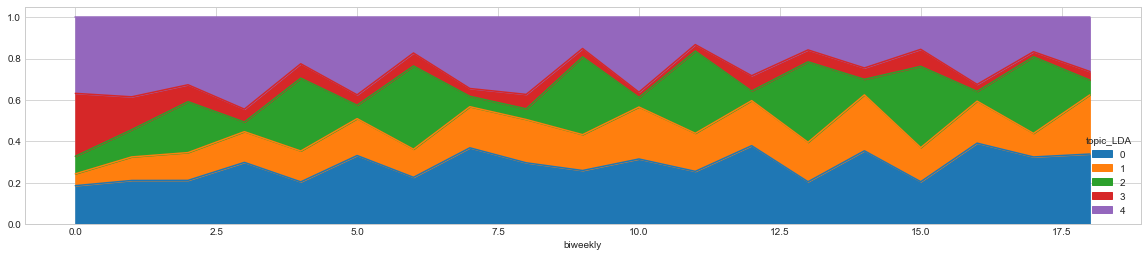

In [101]:
# sns.heatmap(topic_perc, cmap = 'Blues')
#import plotly
#plotly.tools.set_credentials_file(username='nataliabe', api_key='el7xc0JePnGHBNcU6fnl')
#import plotly.plotly as py
#import cufflinks as cf


#topic_perc.iplot(kind='area', fill=True, colors = ['rgba(67,67,67,1)', 'rgba(115,115,115,1)', 'rgba(49,130,189, 1)', 'rgba(189,189,189,1)'])

topic_perc[:18].plot.area(figsize=(20,4))


## Topic-Sentiment Analysis

In [102]:
df_topic0 = df[df['topic_LDA'] == 0]
df_topic1 = df[df['topic_LDA'] == 1]
df_topic2 = df[df['topic_LDA'] == 2]
df_topic3 = df[df['topic_LDA'] == 3]
df_topic4 = df[df['topic_LDA'] == 4]

print("topic 0 ocurrences: {}".format(len(df_topic0)))
print("topic 1 ocurrences: {}".format(len(df_topic1)))
print("topic 2 ocurrences: {}".format(len(df_topic2)))
print("topic 3 ocurrences: {}".format(len(df_topic3)))
print("topic 4 ocurrences: {}".format(len(df_topic4)))

topic 0 ocurrences: 4987
topic 1 ocurrences: 2895
topic 2 ocurrences: 4061
topic 3 ocurrences: 2562
topic 4 ocurrences: 6427


In [103]:
df_topic0_positive = df_topic0[df_topic0['sentiment'] == 'positive']
df_topic0_negative = df_topic0[df_topic0['sentiment'] == 'negative']
df_topic1_positive = df_topic1[df_topic1['sentiment'] == 'positive']
df_topic1_negative = df_topic1[df_topic1['sentiment'] == 'negative']
df_topic2_positive = df_topic2[df_topic2['sentiment'] == 'positive']
df_topic2_negative = df_topic2[df_topic2['sentiment'] == 'negative']
df_topic3_positive = df_topic3[df_topic3['sentiment'] == 'positive']
df_topic3_negative = df_topic3[df_topic3['sentiment'] == 'negative']
df_topic4_positive = df_topic4[df_topic4['sentiment'] == 'positive']
df_topic4_negative = df_topic4[df_topic4['sentiment'] == 'negative']

topics_sentiment = {"Positive": {"topic 0":len(df_topic0_positive), "topic 1": len(df_topic1_positive), "topic 2": len(df_topic2_positive), "topic 3": len(df_topic3_positive), "topic 4": len(df_topic4_positive)}, "Negative":{"topic 0": len(df_topic0_negative), "topic 1": len(df_topic1_negative), "topic 2": len(df_topic2_negative), "topic 3": len(df_topic3_negative), "topic 4": len(df_topic4_negative)}}

pd.DataFrame(topics_sentiment)

Negative  Positive
topic 0  76        259     
topic 1  77        253     
topic 2  13        1325    
topic 3  87        114     
topic 4  164       786

## Get word clouds

In [104]:
topic0_positive = list(df_topic0_positive['body'])
topic0_negative = list(df_topic0_negative['body'])
topic1_positive = list(df_topic1_positive['body'])
topic1_negative = list(df_topic1_negative['body'])
topic2_positive = list(df_topic2_positive['body'])
topic2_negative = list(df_topic2_negative['body'])
topic3_positive = list(df_topic3_positive['body'])
topic3_negative = list(df_topic3_negative['body'])
topic4_positive = list(df_topic4_positive['body'])
topic4_negative = list(df_topic4_negative['body'])

In [105]:
background_color="white"
stopwords_add = stopwords.words('english') + ["treatment", "procedure", "Coolsculpting", "Love", "I'm", "results", "results", "would", "cool", "sculpting", "stomach", "handle", "handles", "still", "lower", "see", "done", "get"]
#stopwords_add = nltk_stopwords
max_font_size=150
max_words=80
width=1000
height=600

In [106]:
wordcloud_topic0_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic0_positive['body']))
wordcloud_topic0_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic0_negative['body']))
wordcloud_topic1_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic1_positive['body']))
wordcloud_topic1_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic1_negative['body']))
wordcloud_topic2_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic2_positive['body']))
wordcloud_topic2_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic2_negative['body']))
wordcloud_topic3_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic3_positive['body']))
wordcloud_topic3_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic3_negative['body']))
wordcloud_topic4_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic4_positive['body']))
wordcloud_topic4_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic4_negative['body']))

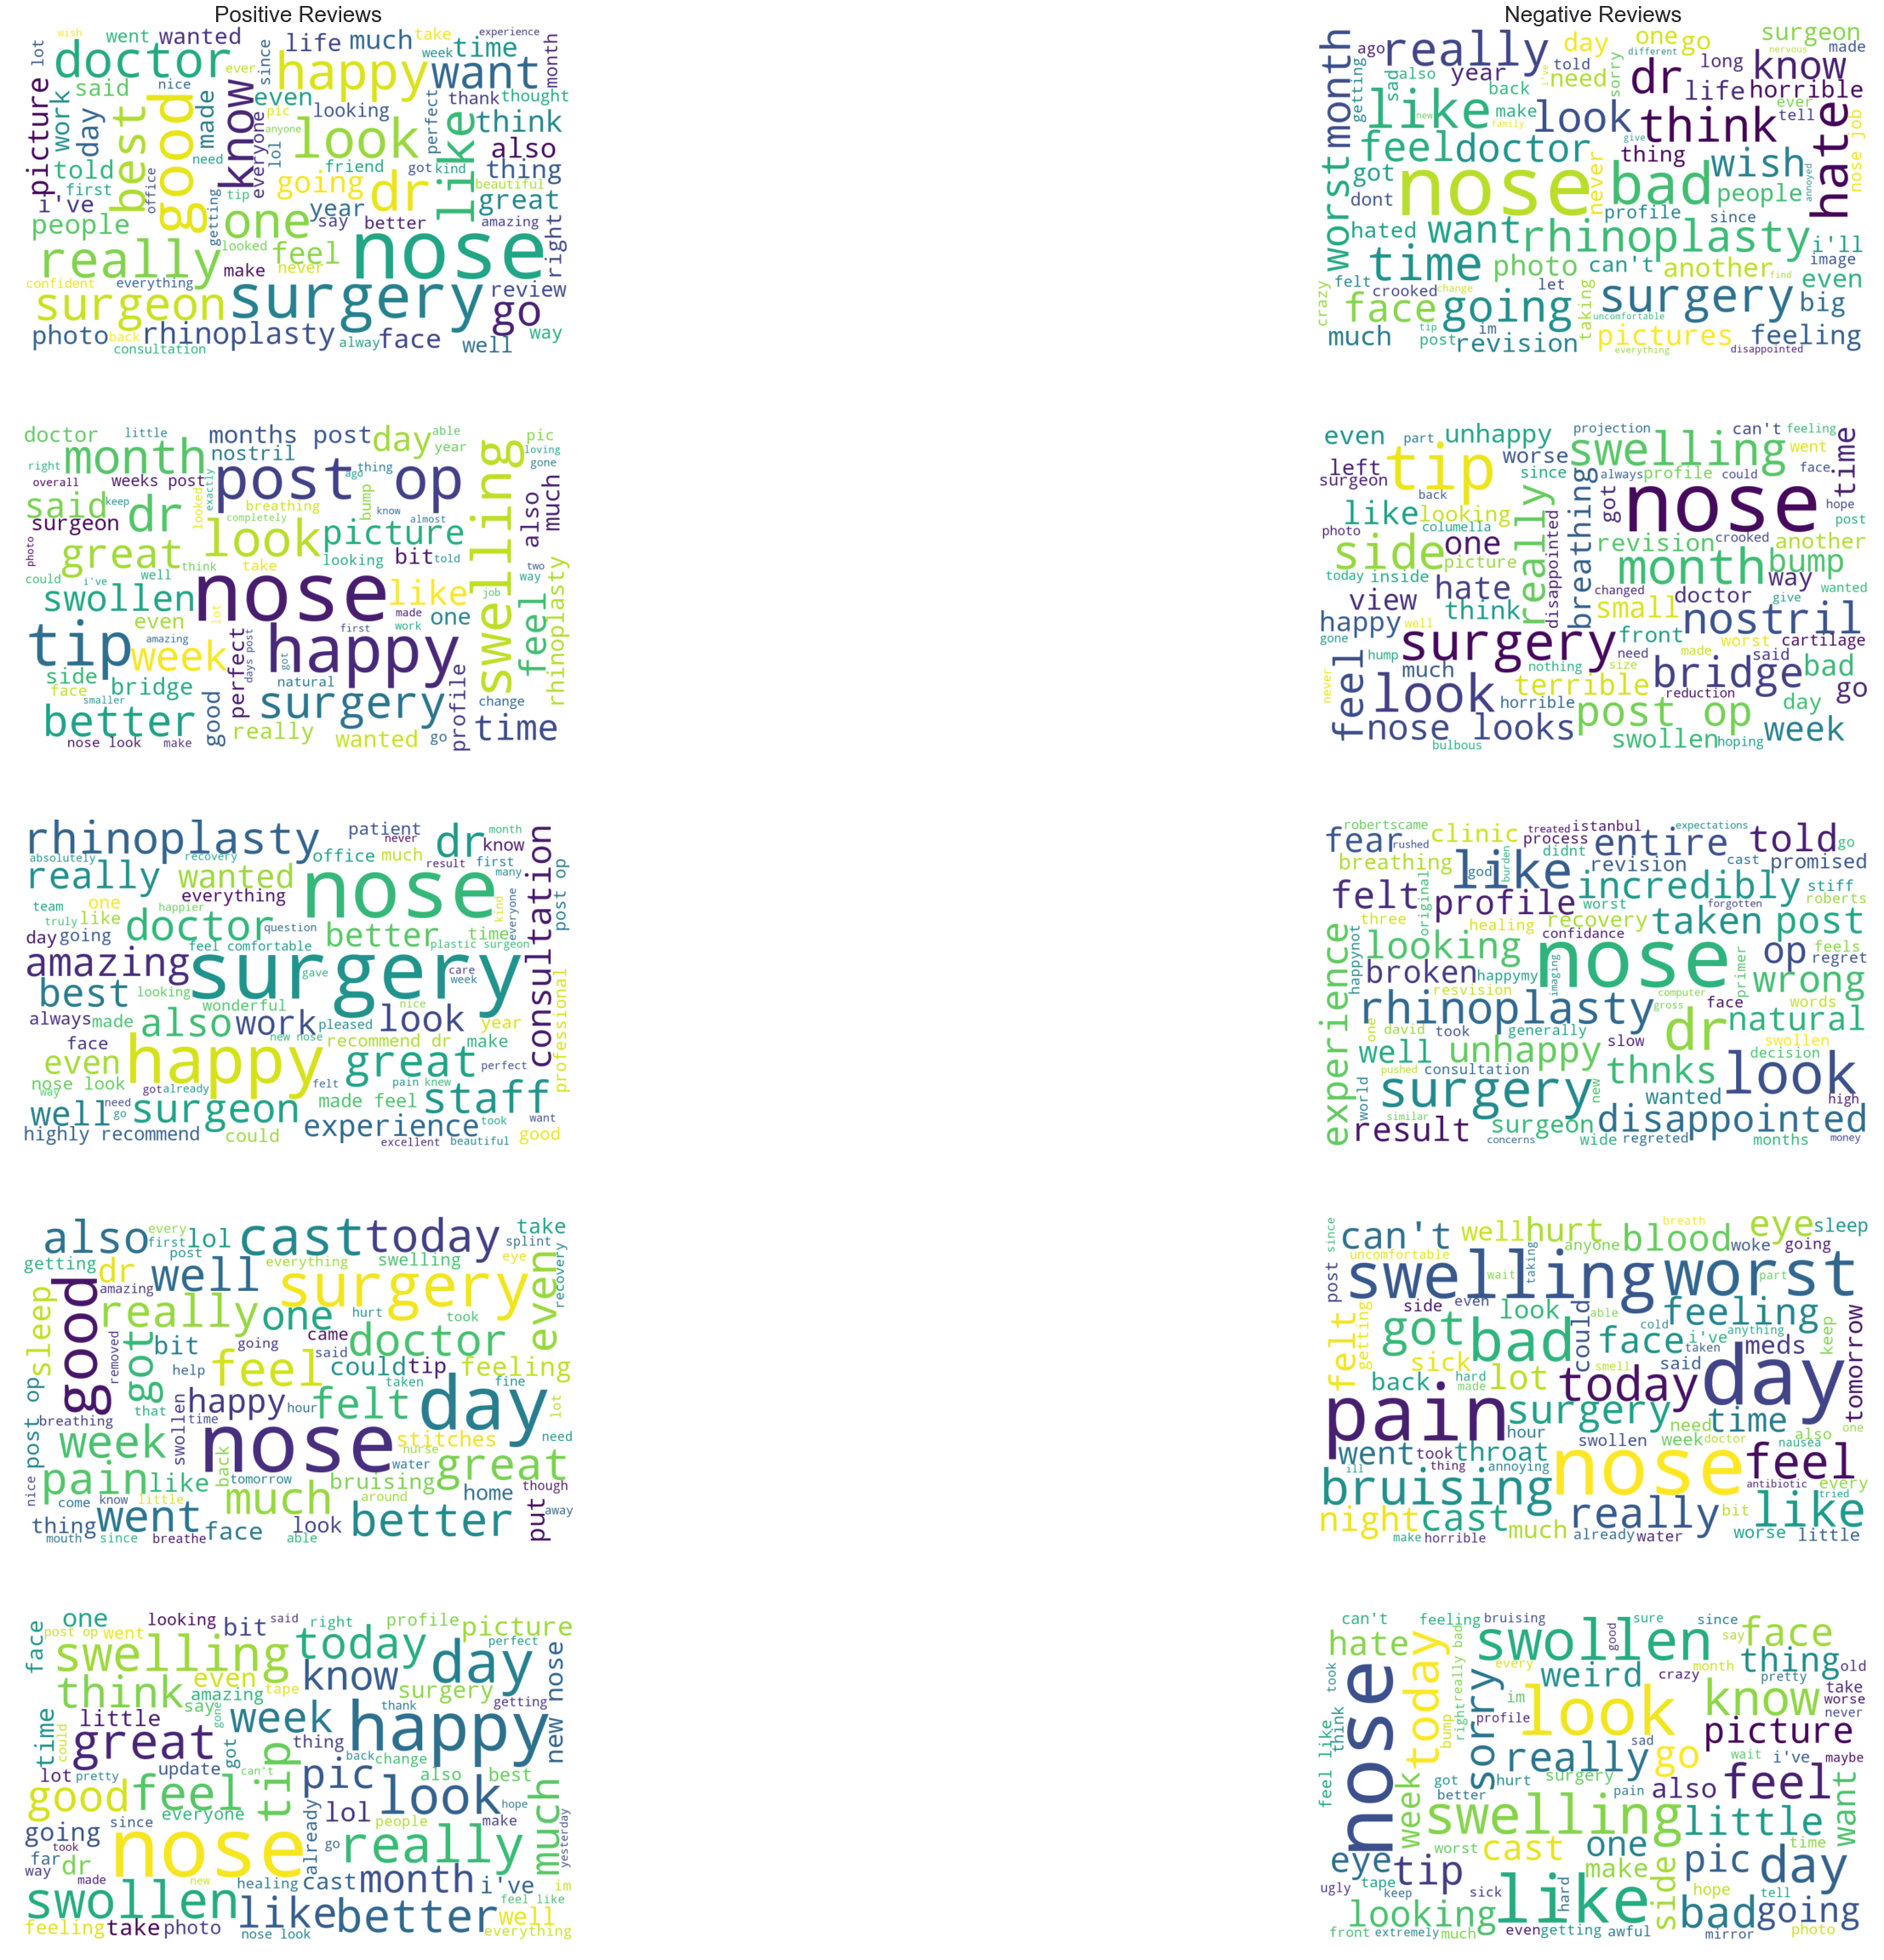

In [107]:
plt.figure(figsize = (50,50))

plt.subplot(6, 2, 1)
plt.imshow(wordcloud_topic0_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Reviews', fontsize=26)

plt.subplot(6, 2, 3)
plt.imshow(wordcloud_topic1_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 5)
plt.imshow(wordcloud_topic2_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 7)
plt.imshow(wordcloud_topic3_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 9)
plt.imshow(wordcloud_topic4_positive, interpolation='bilinear')
plt.axis("off")


plt.subplot(6, 2, 2)
plt.imshow(wordcloud_topic0_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Reviews', fontsize=26)

plt.subplot(6, 2, 4)
plt.imshow(wordcloud_topic1_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 6)
plt.imshow(wordcloud_topic2_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 8)
plt.imshow(wordcloud_topic3_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 10)
plt.imshow(wordcloud_topic4_negative, interpolation='bilinear')
plt.axis("off")

plt.show()

In [109]:
import operator

count_vect = CountVectorizer(stop_words = nltk_stopwords,
                                       max_df = 0.8, ngram_range = (2,4))
matrix = count_vect.fit_transform(df_topic0_negative['body'])
vocab = count_vect.get_feature_names()

print(count_vect.vocabulary_)

#sorted_x = sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
#sorted_x

{'night surgery': 2484, 'surgery course': 3757, 'course find': 757, 'find paper': 1344, 'paper tells': 2802, 'tells everything': 3852, 'everything need': 1114, 'need know': 2418, 'know prepare': 1979, 'prepare extremely': 2995, 'extremely annoyed': 1146, 'annoyed mostly': 173, 'mostly address': 2353, 'address surgery': 66, 'surgery center': 3752, 'center doctors': 613, 'doctors phone': 956, 'phone number': 2866, 'number written': 2696, 'written sure': 4453, 'sure dumb': 3715, 'dumb ass': 1011, 'ass end': 290, 'end taking': 1047, 'taking us': 3829, 'us wrong': 4212, 'wrong place': 4462, 'place ugh': 2923, 'ugh mad': 4127, 'mad also': 2193, 'also never': 139, 'never got': 2459, 'got call': 1542, 'call pharmacy': 565, 'pharmacy med': 2863, 'med scripts': 2244, 'scripts filled': 3381, 'filled sure': 1317, 'sure give': 3718, 'give surgery': 1466, 'center otherwise': 616, 'otherwise feel': 2780, 'feel nervous': 1258, 'nervous really': 2442, 'really feelings': 3100, 'feelings surgery': 1296, 

In [110]:
df[df['worthit'] == "Not Worthit"]

Empty DataFrame
Columns: [body, days_from_procedure, doctor, likes, location, post_date, post_title, price, procedure_date, title, username, worthit, treatment, post_year, body_lem, topic_LDA, weeks_from_procedure, biweekly, months_from_procedure, period, sentences, sentiment_scores, avg_sentiment, sentiment]
Index: []

[0 rows x 24 columns]

In [112]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, stop_words= nltk_stopwords, ngram_range = (2,3))

tfidf = tfidf_vectorizer.fit_transform(df[df['worthit'] == "Not Worth It"]['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('était normal chez', 154118),
 ('était normal', 154117),
 ('élégant est ca', 154116),
 ('élégant est', 154115),
 ('zone surgery cant', 154114),
 ('zone surgery', 154113),
 ('zombie see pictures', 154112),
 ('zombie see', 154111),
 ('zombie actually makes', 154110),
 ('zombie actually', 154109),
 ('zitty skin growing', 154108),
 ('zitty skin', 154107),
 ('zits nose shiny', 154106),
 ('zits nose', 154105),
 ('zits come tape', 154104),
 ('zits come', 154103),
 ('zinnat assured reaction', 154102),
 ('zinnat assured', 154101),
 ('zing old nose', 154100),
 ('zing old', 154099),
 ('zig zags across', 154098),
 ('zig zags', 154097),
 ('zig zagged septum', 154096),
 ('zig zagged back', 154095),
 ('zig zagged', 154094),
 ('zig zag surgery', 154093),
 ('zig zag', 154092),
 ('zest life lost', 154091),
 ('zest life', 154090),
 ('zeroing nose began', 154089),
 ('zeroing nose', 154088),
 ('zero tip work', 154087),
 ('zero tip', 154086),
 ('zero improvement skin', 154085),
 ('zero improvement', 15408

In [113]:
tfidf = tfidf_vectorizer.fit_transform(df_topic0_negative['body'])

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#print (tfidf_vectorizer.vocabulary_)

sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('yesterday fall asleep', 3047),
 ('yesterday fall', 3046),
 ('yep crazy vent', 3045),
 ('yep crazy', 3044),
 ('years nose large', 3043),
 ('years nose', 3042),
 ('years imagined feeling', 3041),
 ('years imagined', 3040),
 ('years ago chris', 3039),
 ('years ago', 3038),
 ('year time pre', 3037),
 ('year time', 3036),
 ('year research decided', 3035),
 ('year research', 3034),
 ('year old crawling', 3033),
 ('year old', 3032),
 ('year feel relieved', 3031),
 ('year feel', 3030),
 ('year another surgery', 3029),
 ('year another', 3028),
 ('yeah hump slightly', 3027),
 ('yeah hump', 3026),
 ('wrote back going', 3025),
 ('wrote back', 3024),
 ('wrong place ugh', 3023),
 ('wrong place', 3022),
 ('wrong mean complain', 3021),
 ('wrong mean', 3020),
 ('wrong came numerous', 3019),
 ('wrong came', 3018),
 ('written sure dumb', 3017),
 ('written sure', 3016),
 ('worth think really', 3015),
 ('worth think', 3014),
 ('worth hard convey', 3013),
 ('worth hard', 3012),
 ('worth feeling used', 30

In [114]:
tfidf = tfidf_vectorizer.fit_transform(df_topic1_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('zacharia said need', 2799),
 ('zacharia said', 2798),
 ('yuck everyone incisions', 2797),
 ('yuck everyone', 2796),
 ('yesterday check skills', 2795),
 ('yesterday check', 2794),
 ('yes slight improvement', 2793),
 ('yes slight', 2792),
 ('yes improved tip', 2791),
 ('yes improved', 2790),
 ('years since revision', 2789),
 ('years since', 2788),
 ('year post surgery', 2787),
 ('year post', 2786),
 ('year mark', 2785),
 ('year decided see', 2784),
 ('year decided', 2783),
 ('wwhaent yesterday check', 2782),
 ('wwhaent yesterday', 2781),
 ('wrong size photos', 2780),
 ('wrong size', 2779),
 ('wrong antibiotic ie', 2778),
 ('wrong antibiotic', 2777),
 ('writing depressed worst', 2776),
 ('writing depressed', 2775),
 ('worth money', 2774),
 ('worth 10 000', 2773),
 ('worth 10', 2772),
 ('worst tip bridge', 2771),
 ('worst tip', 2770),
 ('worst smiles ugly', 2769),
 ('worst smiles', 2768),
 ('worst pictures could', 2767),
 ('worst pictures', 2766),
 ('worst experience life', 2765),
 ('wo

In [115]:
tfidf = tfidf_vectorizer.fit_transform(df_topic2_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('years two ing', 447),
 ('years two', 446),
 ('wrong unhappy lack', 445),
 ('wrong unhappy', 444),
 ('wrong nose going', 443),
 ('wrong nose', 442),
 ('worst nose world', 441),
 ('worst nose', 440),
 ('worse dr waterman', 439),
 ('worse dr', 438),
 ('worried post op', 437),
 ('worried post', 436),
 ('world primer surgery', 435),
 ('world primer', 434),
 ('words generally happy', 433),
 ('words generally', 432),
 ('without asking functionally', 431),
 ('without asking', 430),
 ('whether nose finally', 429),
 ('whether nose', 428),
 ('well fixing sinus', 427),
 ('well fixing', 426),
 ('well aesthetic realignment', 425),
 ('well aesthetic', 424),
 ('waterman explained wrong', 423),
 ('waterman explained', 422),
 ('wanted look different', 421),
 ('wanted look', 420),
 ('utterly lacking communication', 419),
 ('utterly lacking', 418),
 ('unhappy lack professionalism', 417),
 ('unhappy lack', 416),
 ('two ing fro', 415),
 ('two ing', 414),
 ('turned 40 naturally', 413),
 ('turned 40', 412)

In [116]:
tfidf = tfidf_vectorizer.fit_transform(df_topic3_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('zillion side effects', 3820),
 ('zillion side', 3819),
 ('zero sleep last', 3818),
 ('zero sleep', 3817),
 ('yoghurt thats terrible', 3816),
 ('yoghurt thats', 3815),
 ('yesterday surgery everything', 3814),
 ('yesterday surgery', 3813),
 ('yesterday supposed worst', 3812),
 ('yesterday supposed', 3811),
 ('yesterday short since', 3810),
 ('yesterday short', 3809),
 ('yesterday feeling bad', 3808),
 ('yesterday feeling', 3807),
 ('yesterday empty puking', 3806),
 ('yesterday empty', 3805),
 ('yestday worst experience', 3804),
 ('yestday worst', 3803),
 ('yes feel bad', 3802),
 ('yes feel', 3801),
 ('yellow green stuff', 3800),
 ('yellow green', 3799),
 ('yellow bruising taking', 3798),
 ('yellow bruising', 3797),
 ('years though mine', 3796),
 ('years though', 3795),
 ('yay painful adhesive', 3794),
 ('yay painful', 3793),
 ('yawning laughing sneezing', 3792),
 ('yawning laughing', 3791),
 ('xmas presents felt', 3790),
 ('xmas presents', 3789),
 ('wrong suffer days', 3788),
 ('wrong

In [117]:
tfidf = tfidf_vectorizer.fit_transform(df_topic4_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('yet skin also', 4633),
 ('yet skin', 4632),
 ('yet even look', 4631),
 ('yet even', 4630),
 ('yesterday today bad', 4629),
 ('yesterday today', 4628),
 ('yesterday talking bumped', 4627),
 ('yesterday talking', 4626),
 ('yesterday nose looked', 4625),
 ('yesterday nose', 4624),
 ('yesterday making feel', 4623),
 ('yesterday making', 4622),
 ('yesterday high salt', 4621),
 ('yesterday high', 4620),
 ('yellow red face', 4619),
 ('yellow red', 4618),
 ('yellow green coloration', 4617),
 ('yellow green', 4616),
 ('yawn nose flares', 4615),
 ('yawn nose', 4614),
 ('wtf even stand', 4613),
 ('wtf even', 4612),
 ('wrote huge paragraph', 4611),
 ('wrote huge', 4610),
 ('wow phome sucks', 4609),
 ('wow phome', 4608),
 ('woth jt sure', 4607),
 ('woth jt', 4606),
 ('worth status', 4605),
 ('worth see incision', 4604),
 ('worth see', 4603),
 ('worst unexpected thing', 4602),
 ('worst unexpected', 4601),
 ('worst part since', 4600),
 ('worst part itchy', 4599),
 ('worst part', 4598),
 ('worst ma

In [118]:
df_not_worthit.groupby(['topic_notworthit', 'body']).count()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [119]:
df_not_worthit.groupby(['topic_notworthit']).count().reset_index()[['topic_notworthit', 'body']]

topic_notworthit  body
0  0                 488 
1  1                 730 
2  2                 948 
3  3                 330

In [120]:
not_worthit0 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 0]['body'])
not_worthit1 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 1]['body'])
not_worthit2 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 2]['body'])
not_worthit3 =  list(df_not_worthit[df_not_worthit['topic_notworthit'] == 3]['body'])

In [121]:
wordcloud_not_worthit0 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit0))
wordcloud_not_worthit1 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit1))
wordcloud_not_worthit2 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit2))
wordcloud_not_worthit3 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit3))

(-0.5, 999.5, 599.5, -0.5)

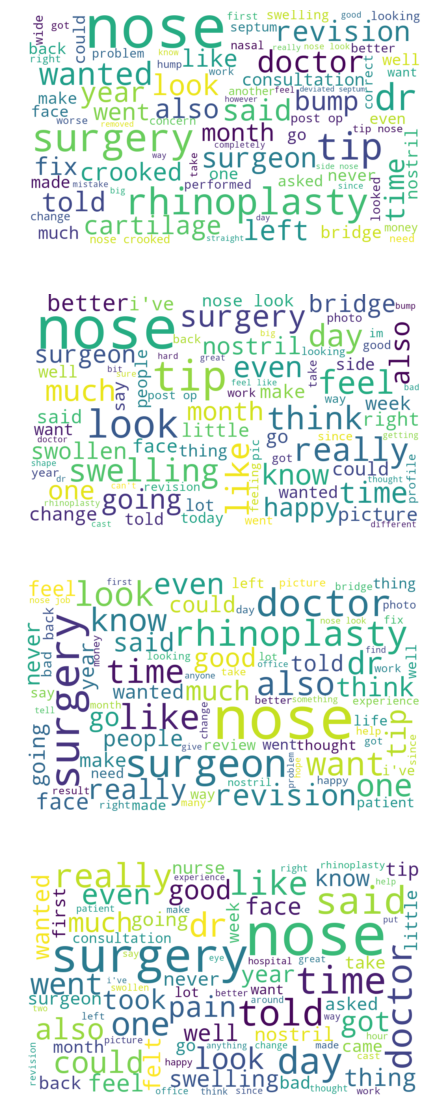

In [122]:
plt.figure(figsize = (20,20))

plt.subplot(4, 1, 1)
plt.imshow(wordcloud_not_worthit0, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud_not_worthit1, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud_not_worthit2, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud_not_worthit3, interpolation='bilinear')
plt.axis("off")


In [123]:
X_negative = [x for x in df_not_worthit['body']]

In [142]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, max_features=no_features, stop_words= nltk_stopwords, ngram_range=(1, 6))


    
tfidf = tfidf_vectorizer.fit_transform(df_not_worthit['body'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components=4, random_state=111, alpha=.1, l1_ratio=.5, init='nndsvd')
X_negative_reduced = nmf.fit_transform(tfidf)
components = nmf.components_
print(components)

[[0.         0.07412813 0.06749621 ... 0.130405   0.16780569 0.00734244]
 [0.12655241 0.07399151 0.         ... 0.         0.02081687 0.07877905]
 [0.         0.01022432 0.         ... 0.         0.         0.03526642]
 [0.         0.07530174 0.         ... 0.         0.         0.        ]]


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [143]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:30],"\n")

topic 0
[('really', 0.8250039250173081), ('feel', 0.7805810497211374), ('look', 0.6500709069812195), ('know', 0.5734012260554514), ('see', 0.569455563083906), ('even', 0.5576178080192695), ('time', 0.5519118267886778), ('think', 0.5426286279607869), ('much', 0.5204186137351146), ('nose', 0.47898356482197635), ('going', 0.45022733659882846), ('happy', 0.44375104712039615), ('people', 0.4244188481763867), ('swelling', 0.4023989327647691), ('good', 0.4003294959535639), ('cast', 0.39996094709724184), ('back', 0.3954184923522103), ('better', 0.3802197021499727), ('surgery', 0.3760386340784257), ('well', 0.37260342783148087), ('today', 0.365249294583553), ('days', 0.3554723345315383), ('face', 0.35330857066994686), ('bad', 0.3461099668166428), ('could', 0.34601984808320146), ('want', 0.34517815467827107), ('pretty', 0.32635035504329024), ('got', 0.3259559376850851), ('lot', 0.31231780914776347), ('since', 0.3067424651083003)] 

topic 1
[('dr', 1.6936944611425135), ('surgery', 1.2171632886562

In [126]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, init="k-means++", random_state=824)
kmeans.fit(X_negative_reduced)
negative_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(X_negative_reduced, negative_labels, metric='euclidean', sample_size=5000, random_state=824))) #memory error

Inertia score: 2.616319540959636
Silhouette score: 0.6586002551869327


In [127]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=824)
tsne_negative = tsne.fit_transform(X_negative_reduced)

In [128]:
df_tsne_negative = pd.DataFrame(tsne_negative, columns=["tsne_x", "tsne_y"])
df_tsne_negative.shape

(2496, 2)

In [129]:
df_tsne_negative["Cluster"] = negative_labels
df_tsne_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 3 columns):
tsne_x     2496 non-null float32
tsne_y     2496 non-null float32
Cluster    2496 non-null int32
dtypes: float32(2), int32(1)
memory usage: 29.3 KB


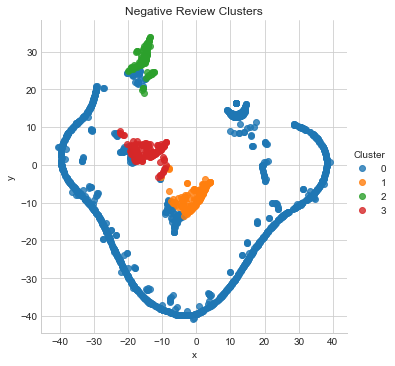

In [130]:
# visualize the negative review clusters using t-SNE
tsne_negative = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_negative, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Negative Review Clusters");

In [131]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#data = pd.read_csv('../input/train.csv').sample(50000, random_state=23)
data = df_not_worthit

In [132]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    data['body'] = data['body'].apply(clean_sentence)
    
    return data

data = clean_dataframe(data)
data.head(5)

<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: Dep

body  \
16  headed poland september 2016 rhinoplasty adam kalecinski call noa clinicprofessional beauty seeing good results reviews facebook page arrived consultation incredibly rushed seemed disinterested felt like conveyor belt lady told 13 operations day left nose aspects worse cannot breathe wonkier front big bump side hooked operation never bumps tip enormous clinic deletes bad reviews posts satisfied patients results look revision uk correct nose go clinic cover things provide ignore emails rush provide honestly minimum result impacted life beyond belief                        
17  hi everyone writing share details experience rhinoplasty dr boahene\n             \n             dr boahene lovely sure talented get best result\n             \n             surgery april 2015 soon cast removed noticed nose straight something improved since still looks weird esp pictures\n             \n             worst part much difficulty breathing esp night always looks like cold nose always stuffed\n             \n             looking get revision future maybe go dr not\n             \n             upload pictures later\n             \n             happy new year   
18  breathing still hard prescribed steroid nasal pray family doctor helping cant breath sleeping left side nostrils blocked sent dr b email last month answered telling would need see consult sent another email couple weeks ago ask opinion explain difficult see live far full time students wanted answer one question regarding revision even bother reply looks like look another surgeon revision possibly dr hamilton                                                                                                                                                                       
70  dr graper performed tip rhinoplasty 18 years old 23 years old honestly say biggest waste money time expressed concern post brushed 1 year later went visit rude told wasnt capable performing wanted wasnt fault disagreed expectations however never mentioned preop receive rhinoplasty doctor youll regret                                                                                                                                                                                                                                                                                     
76  happy amount paid shouldnt look like barely anything done  theres dent tip nose cant fixed dont wanna post pictures \n            \n            said gonna put pics site didnt think knows messed                                                                                                                                                                                                                                                                                                                                                                                                 

    days_from_procedure            doctor likes     location  post_date  \
16  180                                    2                 2017-03-01   
17  365                                    2                 2017-01-07   
18  393                                    0                 2017-02-04   
70  17155                                  0                 2017-02-07   
76  365                  Jamil Asaria, MD  0     Toronto, ON 2016-08-26   

                                           post_title    price  \
16  Had Botched rhinoplasty Adam Kalecinski Poland     $2,000    
17  Can't breath after my rhinoplasty with Dr Boahene  $10,000   
18  breathing is still hard but i was…                 $10,000   
70  18 year old rhinoplasty journey                    $4,300    
76  Not happy. For the amount I paid its shouldn't...  $8,001    

         procedure_date                                              title  \
16  2016-09-02 00:00:00  Had Botched rhinoplasty Adam Kalecinski Poland      
17  2016-01-08 00:00:00  Can't breath after my rhinoplasty with Dr Boahe

In [133]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['body'].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['headed',
  'poland',
  'september',
  '2016',
  'rhinoplasty',
  'adam',
  'kalecinski',
  'call',
  'noa',
  'clinicprofessional',
  'beauty',
  'seeing',
  'good',
  'results',
  'reviews',
  'facebook',
  'page',
  'arrived',
  'consultation',
  'incredibly',
  'rushed',
  'seemed',
  'disinterested',
  'felt',
  'like',
  'conveyor',
  'belt',
  'lady',
  'told',
  '13',
  'operations',
  'day',
  'left',
  'nose',
  'aspects',
  'worse',
  'cannot',
  'breathe',
  'wonkier',
  'front',
  'big',
  'bump',
  'side',
  'hooked',
  'operation',
  'never',
  'bumps',
  'tip',
  'enormous',
  'clinic',
  'deletes',
  'bad',
  'reviews',
  'posts',
  'satisfied',
  'patients',
  'results',
  'look',
  'revision',
  'uk',
  'correct',
  'nose',
  'go',
  'clinic',
  'cover',
  'things',
  'provide',
  'ignore',
  'emails',
  'rush',
  'provide',
  'honestly',
  'minimum',
  'result',
  'impacted',
  'life',
  'beyond',
  'belief'],
 ['hi',
  'everyone',
  'writing',
  'share',
  'detai

In [135]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['nose']

2018-03-08 23:01:12,428 : INFO : collecting all words and their counts
2018-03-08 23:01:12,431 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-08 23:01:12,476 : INFO : collected 15547 word types from a corpus of 296090 raw words and 2496 sentences
2018-03-08 23:01:12,478 : INFO : Loading a fresh vocabulary
2018-03-08 23:01:12,485 : INFO : min_count=200 retains 183 unique words (1% of original 15547, drops 15364)
2018-03-08 23:01:12,487 : INFO : min_count=200 leaves 185027 word corpus (62% of original 296090, drops 111063)
2018-03-08 23:01:12,489 : INFO : deleting the raw counts dictionary of 15547 items
2018-03-08 23:01:12,491 : INFO : sample=0.001 downsamples 59 most-common words
2018-03-08 23:01:12,493 : INFO : downsampling leaves estimated 75587 word corpus (40.9% of prior 185027)
2018-03-08 23:01:12,496 : INFO : estimated required memory for 183 words and 100 dimensions: 237900 bytes
2018-03-08 23:01:12,498 : INFO : resetting layer weights
2018-03

array([ 0.02975728,  0.0925613 , -0.12245884, -0.31246197,  0.26495412,
       -0.34682798, -0.15954308, -0.17427328,  0.06703356, -0.24278405,
       -0.19553691,  0.76807773,  0.29878372,  0.3960727 ,  0.48175302,
        0.14616838, -0.7131533 , -0.39584857, -0.22275452,  0.2838592 ,
       -0.2956272 , -0.32762703,  0.26268786,  0.42293903,  0.22777024,
       -0.09939048, -0.39853585,  0.19567597, -0.24466568,  0.61710024,
       -0.79230005, -0.08505528,  0.39284065, -0.3034236 ,  0.0347852 ,
       -0.23374341, -0.42578274, -0.29863435,  0.15351179,  0.5667797 ,
       -0.5289439 , -0.7781494 ,  0.2784396 ,  1.0315851 ,  0.16830532,
        0.0335662 ,  0.961356  ,  0.19722413,  0.17309366, -0.511454  ,
       -0.14489684,  0.02557563, -0.05151639, -0.07018897, -0.11317754,
       -0.1994881 ,  0.22601534,  0.5260841 , -0.18837583,  1.0552506 ,
       -0.24751893, -0.42655203, -0.15379566,  0.06658386,  0.5515894 ,
        0.20509957, -0.10106255,  0.3586029 , -0.5607346 , -0.35

In [136]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call t

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call t

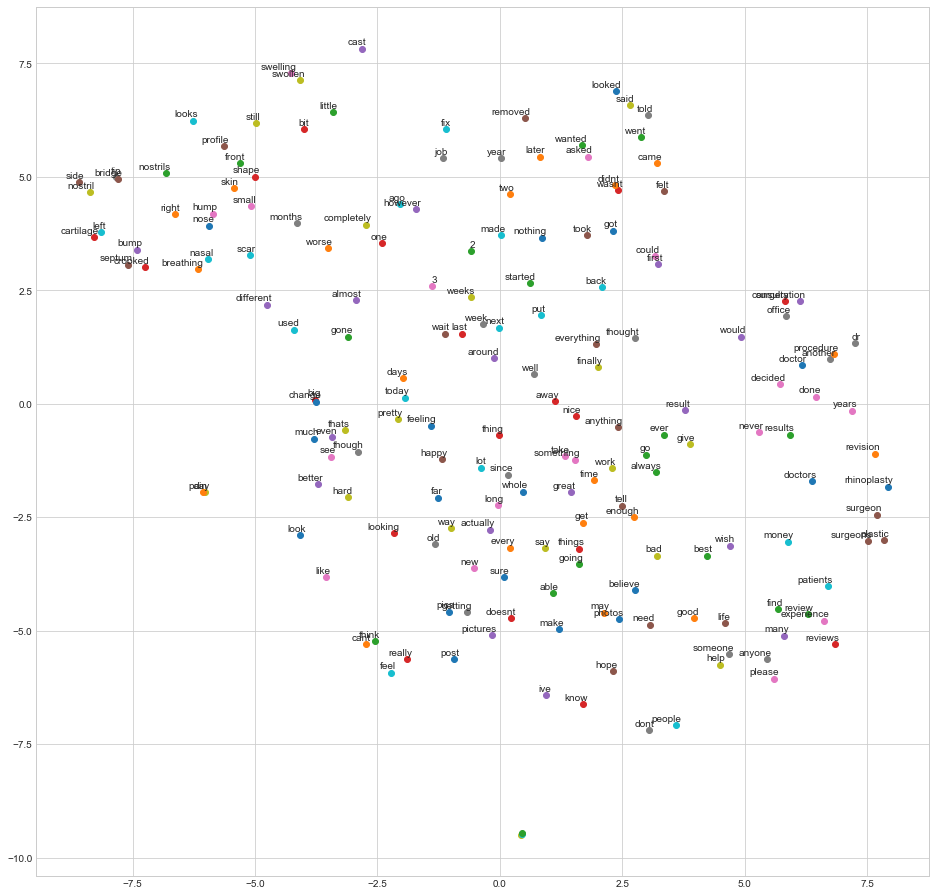

In [137]:
tsne_plot(model)

2018-03-08 23:01:41,196 : INFO : collecting all words and their counts
2018-03-08 23:01:41,199 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-08 23:01:41,247 : INFO : collected 15547 word types from a corpus of 296090 raw words and 2496 sentences
2018-03-08 23:01:41,250 : INFO : Loading a fresh vocabulary
2018-03-08 23:01:41,257 : INFO : min_count=100 retains 380 unique words (2% of original 15547, drops 15167)
2018-03-08 23:01:41,259 : INFO : min_count=100 leaves 211862 word corpus (71% of original 296090, drops 84228)
2018-03-08 23:01:41,263 : INFO : deleting the raw counts dictionary of 15547 items
2018-03-08 23:01:41,265 : INFO : sample=0.001 downsamples 50 most-common words
2018-03-08 23:01:41,267 : INFO : downsampling leaves estimated 105687 word corpus (49.9% of prior 211862)
2018-03-08 23:01:41,270 : INFO : estimated required memory for 380 words and 100 dimensions: 494000 bytes
2018-03-08 23:01:41,273 : INFO : resetting layer weights
2018-03

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call t

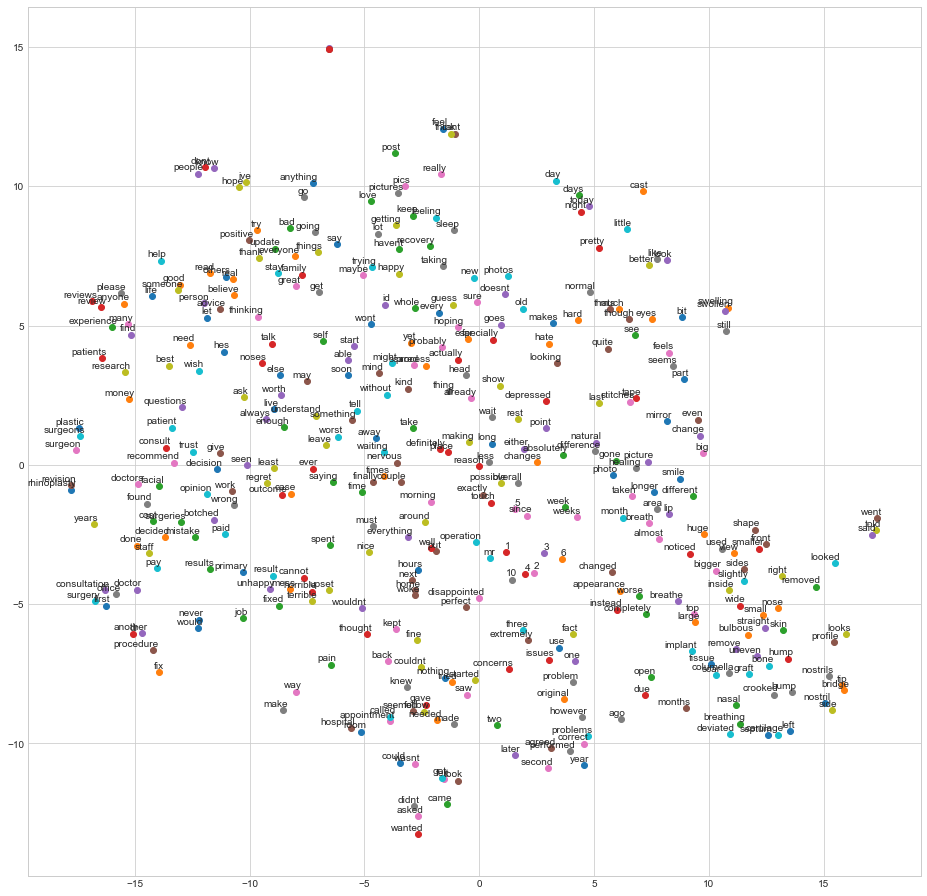

In [138]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)